# K-means Clustering

In [318]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np


# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

%load_ext autoreload
%autoreload 2


# tells matplotlib to embed plots within the notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). You will implement the two phases of the K-means algorithm separately
in the next sections.

<a id="section1"></a>
#### 1.1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

Your task is to complete the code in the function `findClosestCentroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.
<a id="findClosestCentroids"></a>

In [319]:
def findClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    
    Instructions
    ------------
    Go over every example, find its closest centroid, and store
    the index inside `idx` at the appropriate location.
    Concretely, idx[i] should contain the index of the centroid
    closest to example i. Hence, it should be a value in the 
    range 0..K-1

    Note
    ----
    You can use a for-loop over the examples to compute this.
    """
    # idx is a vector of all indices of the closest centoid
    idx = []
    distance = []
    for i in range(X.shape[0]):
        for j in range(len(centroids)):
            distance.append(np.sqrt(np.sum((X[i]-centroids[j])**2)))
            #distance.append(np.sqrt(np.sum(np.square(X[i]-centroids[j]))))
      
        idx.append( (distance.index(min(distance))))
        distance = []
    
    return idx

Once you have completed the code in `findClosestCentroids`, the following cell will run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

In [320]:
# Load an example dataset that we will be using
data = loadmat(os.path.join('data', 'ex7data2.mat'))
X = data['X']

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0, 2, 1]
(the closest centroids should be 0, 2, 1 respectively)


<a id="section2"></a>
### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.



In [321]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    
    Instructions
    ------------
    Go over every centroid and compute mean of all points that
    belong to it. Concretely, the row vector centroids[i, :]
    should contain the mean of the data points assigned to
    cluster i.

    Note:
    -----
    You can use a for-loop over the centroids to compute this.
    """
    centroids = np.empty((K,X.shape[1]))
    for i in range(0,K):
        data = []
        n = 0
        for j in range(len(idx)):
            if idx[j] == i:
                data.append(X[j])
        
        centroids[i] = np.sum(data, axis = 0) / len(data)
        #centroids[i] = (np.mean(data, axis = 0))
        

    return centroids

Once you have completed the code in `computeCentroids`, the following cell will run your code and output the centroids after the first step of K-means.

In [322]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


### 1.2 K-means on example dataset 

After you have completed the two functions (`findClosestCentroids` and `computeCentroids`), you have all the necessary pieces to run the K-means algorithm. The next cell  will run the K-means algorithm on a toy 2D dataset to help you understand how K-means works. Your functions are called from inside the `runKmeans` function (in this assignment's `utils.py` module). We encourage you to take a look at the function to understand how it works. Notice that the code calls the two functions you implemented in a loop.

When you run the next step, the K-means code will produce an animation that steps you through the progress of the algorithm at each iteration. At the end, your figure should look as the one displayed below.

![](Figures/kmeans_result.png)

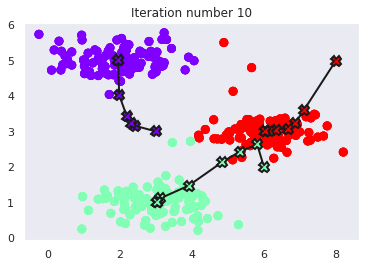

In [323]:
# Load an example dataset
data = loadmat(os.path.join('data', 'ex7data1.mat'))

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])


# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx, anim = utils.runkMeans(X, initial_centroids,
                                       findClosestCentroids, computeCentroids, max_iters, True)
anim

### 1.3 Random initialization 

The initial assignments of centroids for the example dataset in the previous cell were designed so that you will see the same figure as that shown in the cell above. In practice, a
good strategy for initializing the centroids is to select random examples from the training set.



In [324]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    
    Instructions
    ------------
    You should set centroids to randomly chosen examples from the dataset X.
    """
    centroids = np.empty((K,X.shape[1]))
    for i in range(K):

        centroids[i] = (X[np.random.choice(X.shape[0], 1, replace=False)])[0].tolist()
   
    return centroids

In [254]:
kMeansInitCentroids(X, K)

array([[1.97619886, 4.43489674],
       [0.94623208, 0.24522253],
       [2.17777173, 4.86154019]])

#### Number of iterations

In [325]:
def stop_iterating(centroids, oldCentroids):
    '''Determines if the algorithm has converged 
        by comparing the centroids between two consecutive 
        iterations. '''
    return np.allclose(centroids,oldCentroids)

## K-means

In [326]:
def k_kmeans(X,K,iterations):
    centroids = kMeansInitCentroids(X, K)
    for i in range(iterations):
        idx = findClosestCentroids(X, centroids)
        oldCentroids = centroids
        centroids = computeCentroids(X, idx, K)
        
        if stop_iterating(centroids, oldCentroids):
            break
    return centroids, idx
        

#### Predicting data labels

In [327]:
def predict(centroids, X):
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label
    labels = []
    for i in range(X.shape[0]):
        labels.append(findClosestCentroids(X, centroids)[i])
        
    return labels

### How to pick K
* Elbow method

In [300]:
def elbow(X):
    dist = []
    distortion = []
    inertia = []
    for j in range(0,10):
        sums = []
        centroids = kMeansInitCentroids(X, j+1)
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, j+1)
        for t in range(j+1):
            for i in range(X.shape[0]):
                if idx[i] == t:
                    dist.append((((X[i][0]-centroids[idx[i]][0])**2) + ((X[i][1]-centroids[idx[i]][1])**2)))
            sums.append(sum(dist))
            dist = []
        distortion.append(np.sum(sums)/(j+1))
     
    args = [0]
    for i in range(len(distortion)-1):
        args.append(distortion[i]-(distortion[i+1]))
    argmax = max(args)
    k = args.index(argmax) + 1
    return distortion, k


In [301]:
distortions,k = elbow(X)

In [302]:
k

2

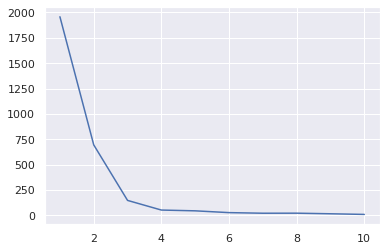

In [303]:
mpl.pyplot.plot(range(1,11), distortions)

### Inertia

In [315]:
# k-1 as distortion indices start from 0
distortions[k-1]  

695.4393530845794

### Plotting data & centroids

/home/ayah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ayah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

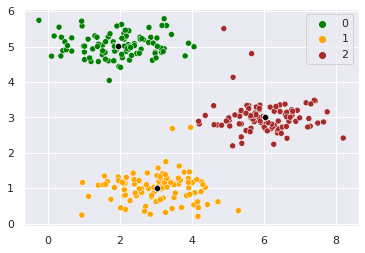

In [332]:
import seaborn as sns
sns.scatterplot(X[:,0],X[:,1], hue = predict(centroids, X), palette=['green','orange','brown'], legend='full')
sns.scatterplot(centroids[idx][:,0], centroids[idx][:,1], color = 'black')

## Kmeans Class

In [333]:
class kmeans:
    def __init__(self,iterations,X,K):
        self.iterations=iterations
        self.X=X
        self.K=K
        
    def kMeansInitCentroids(self):
        centroids = np.empty((self.K,self.X.shape[1]))
        for i in range(self.K):
            centroids[i] = (self.X[np.random.choice(self.X.shape[0], 1, replace=False)])[0].tolist()
        return centroids
    
    def findClosestCentroids(self,centroids):
        idx = []
        distance = []
        for i in range(self.X.shape[0]):
            for j in range(len(centroids)):
                distance.append(np.sqrt(np.sum((self.X[i]-centroids[j])**2)))
                #distance.append(np.sqrt(np.sum(np.square(X[i]-centroids[j]))))

            idx.append( (distance.index(min(distance))))
            distance = []

        return idx
    
    
    def computeCentroids(self,idx):
        centroids = np.empty((self.K, self.X.shape[1]))
        for i in range(0,self.K):
            data = []
            for j in range(len(idx)):
                if idx[j] == i:
                    data.append(self.X[j])

            centroids[i] = np.sum(data, axis = 0) / len(data)
            #centroids[i] = (np.mean(data, axis = 0))


        return centroids
    
    def predict(self,centroids):
        labels = []
        for i in range(X.shape[0]):
            labels.append(findClosestCentroids(X, centroids)[i])
        return labels
    
  
    
    def stop_iterating(self,centroids, oldCentroids):
        return np.allclose(centroids,oldCentroids)
    
    def fit(self):
        centroids = self.kMeansInitCentroids()
        for i in range(self.iterations):
            idx = self.findClosestCentroids(centroids)
            oldCentroids = centroids
            centroids = self.computeCentroids(idx)

            if self.stop_iterating(centroids, oldCentroids):
                break
        return centroids, idx


In [340]:
obj = kmeans(1000,X,k)

In [341]:
centroids = obj.kMeansInitCentroids()


In [342]:
idx = obj.findClosestCentroids(centroids)

In [343]:
centroids = obj.computeCentroids(idx)

In [344]:
labels = obj.predict(centroids)

In [345]:
kmean = obj.fit()
kmean[0]

array([[1.98363152, 5.03043004],
       [4.52205549, 1.9806849 ]])

### K means with sklearn

In [346]:
from sklearn.cluster import KMeans

In [347]:
model = KMeans(n_clusters= k)
model.fit(X)

KMeans(n_clusters=2)

In [348]:
centroids = model.cluster_centers_
centroids

array([[4.52205549, 1.9806849 ],
       [1.98363152, 5.03043004]])

In [349]:
labels = model.predict(X)

In [350]:
model.inertia_

913.3192714747096

2


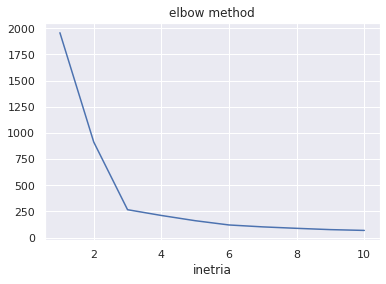

In [351]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
scores = []
k = np.arange(1,11)
cost = []
for i in k:
    kmeans = KMeans(n_clusters = i).fit(X)
    cost.append(kmeans.inertia_)
sns.set()
plt.plot(k, cost)
plt.title("elbow method")
plt.xlabel("K")
plt.xlabel("inetria")


# check best k
args = [0]
for i in range(len(cost)-1):
    args.append(cost[i]-(cost[i+1]))
argmax = max(args)
k = args.index(argmax) + 1
print(k)